# Training Siamese

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/M6-T6-Project-master/Week5

/content/drive/MyDrive/M6-T6-Project-master/Week5


In [ ]:
!mkdir '/content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches/'
!unzip '/content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches.zip' -d '/content/drive/MyDrive/M6-T6-Project-master/Week5/gt'


mkdir: cannot create directory ‘/content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches/’: File exists
Archive:  /content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches.zip
replace /content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches/1_S01_c002_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pip install umap-learn
!pip install record-keeper
!pip install pytorch-metric-learning
!apt install libomp-dev
!pip install faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as pltImage

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import  transforms

import umap
import record_keeper
from cycler import cycler

import pytorch_metric_learning
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
#Paths
gt_csv = '/content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches_annotations.csv'  #path to gt csv containing annotations
gt_patches = '/content/drive/MyDrive/M6-T6-Project-master/Week5/gt/gt_car_patches/'             #path to gt folder containing car patches
save_model = '/content/drive/MyDrive/M6-T6-Project-master/Week5/model/'                         #path to save trained model

#Hyper-parameters
epochs = 10                 #number of epochs to train
lr = 0.001                  #learning rate
batch_size = 32             #batch size
embeddings = 256            #number of embeddings

In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)


trans_train = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((64,64)),
                            transforms.ToTensor(),
                        ])

trans_test = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((64,64)),
                            transforms.ToTensor(),
                        ])

INFO:root:VERSION 1.3.0


In [ ]:
class CarsDataset(Dataset):
    def __init__(self, data, path, transform=trans_train):
        super().__init__()
        self.data = list(data.values[:, 0])
        self.targets = list(data.values[:, 1])
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = self.data[index]
        label = self.targets[index]
        img_path = os.path.join(self.path, (str(img_name)))
        image = pltImage.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]   #layer_size = [512,64]
        num_layers = len(layer_sizes) - 1      #len(layer_size)= 2
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]     #input MLP
            curr_size = layer_sizes[i + 1]  #output MLP
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))   #add a linear layer of (512,64) to empty list
        self.net = nn.Sequential(*layer_list)   #create a sequential network with one or more Linear layers
        self.last_linear = self.net[-1]         #store last linear layer

    def forward(self, x):
        return self.net(x)

In [ ]:
def get_data_loader(split, labels, patches_path):
    if split == 'train':
        df = labels[labels['FILENAME'].str.contains('S01|S04')].sample(frac=1)
        #print(df)
        data = CarsDataset(df, patches_path, trans_train)
        loader = DataLoader(dataset=data, batch_size=32, shuffle=True)
    else:
        df = labels[labels['FILENAME'].str.contains('S03')].sample(frac=1)
        #print(df)
        data = CarsDataset(df, patches_path, trans_test)
        loader = DataLoader(dataset=data, batch_size=32)
    return data, loader

In [ ]:
import pandas as pd

labels = pd.read_csv(gt_csv)
train_data, train_loader = get_data_loader('train', labels, gt_patches)
test_data, test_loader = get_data_loader('test', labels, gt_patches)

print(f"Train size: {len(train_data)} Test size: {len(test_data)}")

Train size: 38074 Test size: 6174


In [ ]:
def train(train_data, test_data, save_model, num_epochs, lr, embedding_size, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set trunk model and replace the softmax layer with an identity function
    trunk = torchvision.models.resnet18(pretrained=True)
    trunk_output_size = trunk.fc.in_features  #dim=512
    trunk.fc = common_functions.Identity()    #replace last fc by an Identity function
    trunk = torch.nn.DataParallel(trunk.to(device))

    # Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
    embedder = torch.nn.DataParallel(MLP([trunk_output_size, embedding_size]).to(device))  #pass through an MLP a list of (two) layer dims (one linear layer)

    # Set optimizers
    trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=lr/10, weight_decay=0.0001)
    embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=lr, weight_decay=0.0001)

    # Set the loss function
    loss = losses.TripletMarginLoss(margin=0.1)

    # Set the mining function
    miner = miners.MultiSimilarityMiner(epsilon=0.1)  #Negative (positive) pairs are chosen if they have similarity greater (less) 
                                                      #than the hardest positive (negative) pair, minus (plus) this margin epsilon.
                                                      #default distance: cosine similarity
    
    # Set the dataloader sampler (purpose of samplers: determine how batches should be formed)
    sampler = samplers.MPerClassSampler(train_data.targets, m=4, length_before_new_iter=len(train_data))

    save_dir = os.path.join(save_model,
                            ''.join(str(lr).split('.')) + '_' + str(batch_size) + '_' + str(embedding_size))

    os.makedirs(save_dir, exist_ok=True)

    # Package the above stuff into dictionaries
    models = {"trunk": trunk, "embedder": embedder}
    optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
    loss_funcs = {"metric_loss": loss}
    mining_funcs = {"tuple_miner": miner}

    record_keeper, _, _ = logging_presets.get_record_keeper(os.path.join(save_dir, "example_logs"),
                                                            os.path.join(save_dir, "example_tensorboard"))
    hooks = logging_presets.get_hook_container(record_keeper)

    dataset_dict = {"val": test_data, "train": train_data}
    model_folder = "example_saved_models"

    def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
        logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
        label_set = np.unique(labels)
        num_classes = len(label_set)
        fig = plt.figure(figsize=(20, 15))
        plt.title(str(split_name) + '_' + str(embedding_size))
        plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
        for i in range(num_classes):
            idx = labels == label_set[i]
            plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
        plt.show()

    # Create the tester, GlobalEmbeddingSpaceTester: computes nearest neighbors by looking at all points in the embedding space
    tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook=hooks.end_of_testing_hook,
                                                visualizer=umap.UMAP(),
                                                visualizer_hook=visualizer_hook,
                                                dataloader_num_workers=2,
                                                accuracy_calculator=AccuracyCalculator(k="max_bin_count"))

    end_of_epoch_hook = hooks.end_of_epoch_hook(tester,
                                                dataset_dict,
                                                model_folder,
                                                test_interval=1,
                                                patience=1)

    trainer = trainers.MetricLossOnly(models,
                                      optimizers,
                                      batch_size,
                                      loss_funcs,
                                      mining_funcs,
                                      train_data,
                                      sampler=sampler,
                                      dataloader_num_workers=2,
                                      end_of_iteration_hook=hooks.end_of_iteration_hook,
                                      end_of_epoch_hook=end_of_epoch_hook)

    trainer.train(num_epochs=num_epochs)

    if save_model is not None:

        torch.save(models["trunk"].state_dict(), os.path.join(save_dir, 'trunk.pth'))
        torch.save(models["embedder"].state_dict(), os.path.join(save_dir, 'embedder.pth'))

        print('Model saved in ', save_dir)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=0.16277: 100%|██████████| 1182/1182 [02:02<00:00,  9.64it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:34<00:00, 12.62it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:18<00:00, 10.27it/s]
INFO:PML:Running UMAP on the train set
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


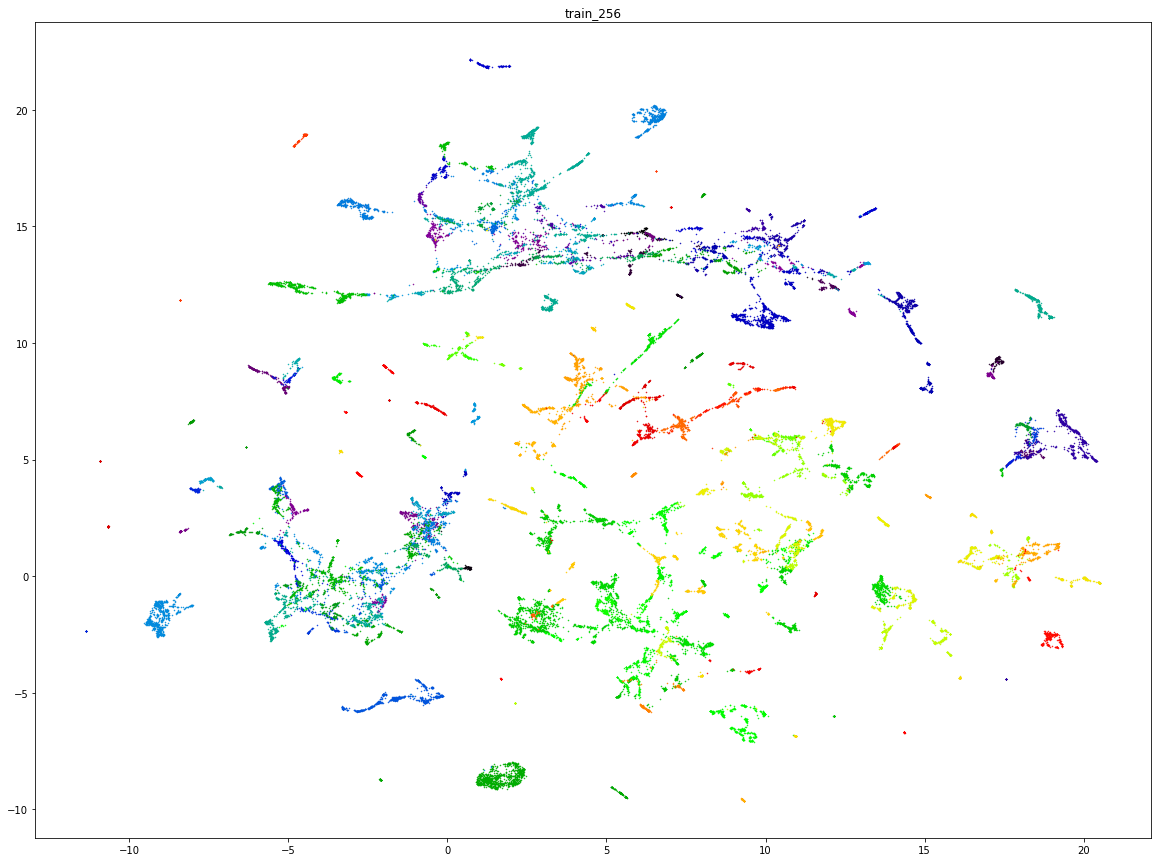

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


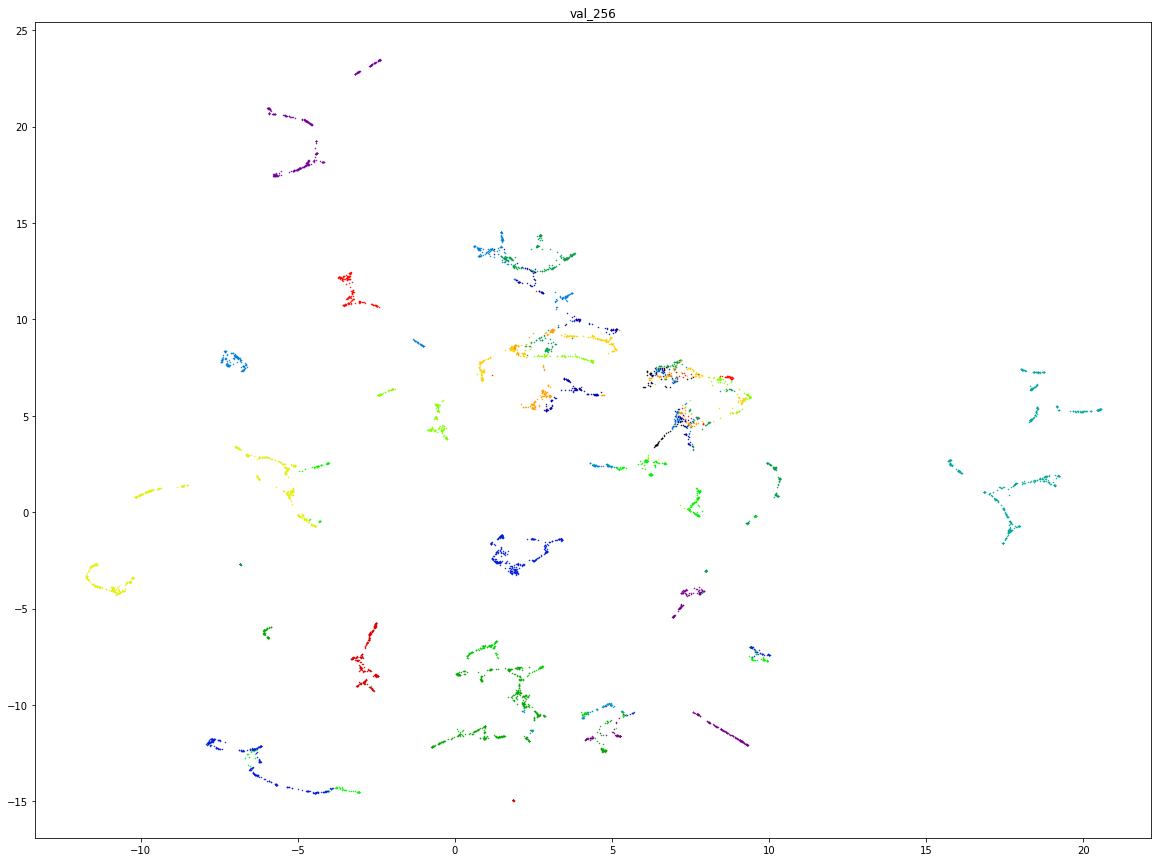

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:TRAINING EPOCH 2
total_loss=0.04901: 100%|██████████| 1182/1182 [01:56<00:00, 10.14it/s]
INFO:PML:Evaluating epoch 2
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:33<00:00, 12.69it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:16<00:00, 11.37it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


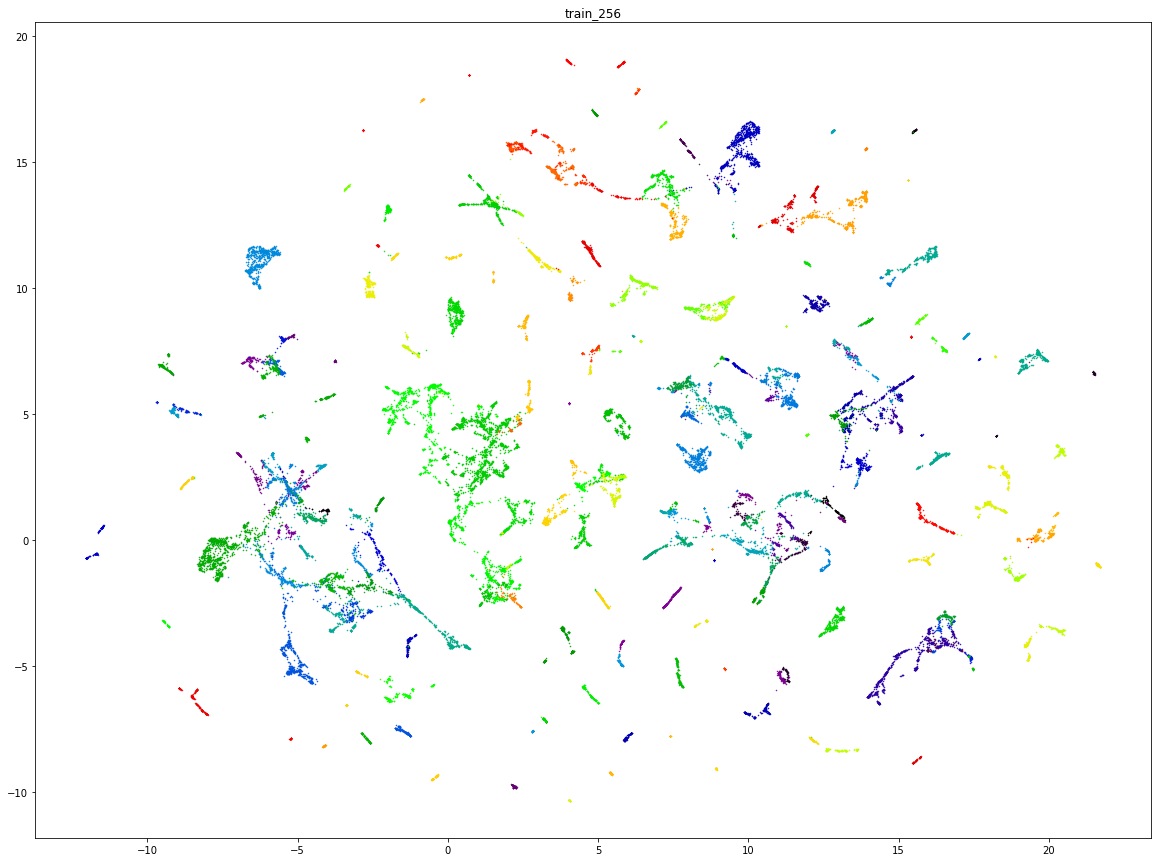

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


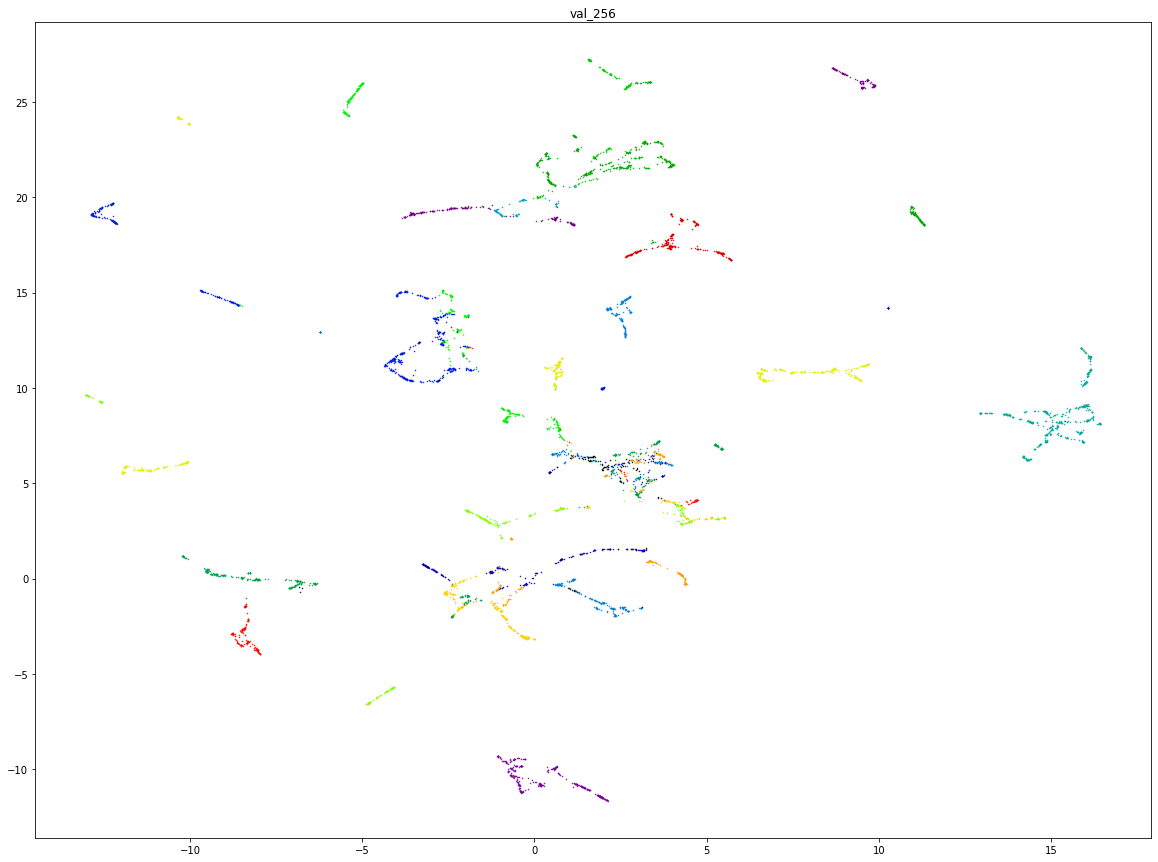

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.4330790097927569
INFO:PML:TRAINING EPOCH 3
total_loss=0.07412: 100%|██████████| 1182/1182 [02:00<00:00,  9.80it/s]
INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:34<00:00, 12.59it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:17<00:00, 11.02it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


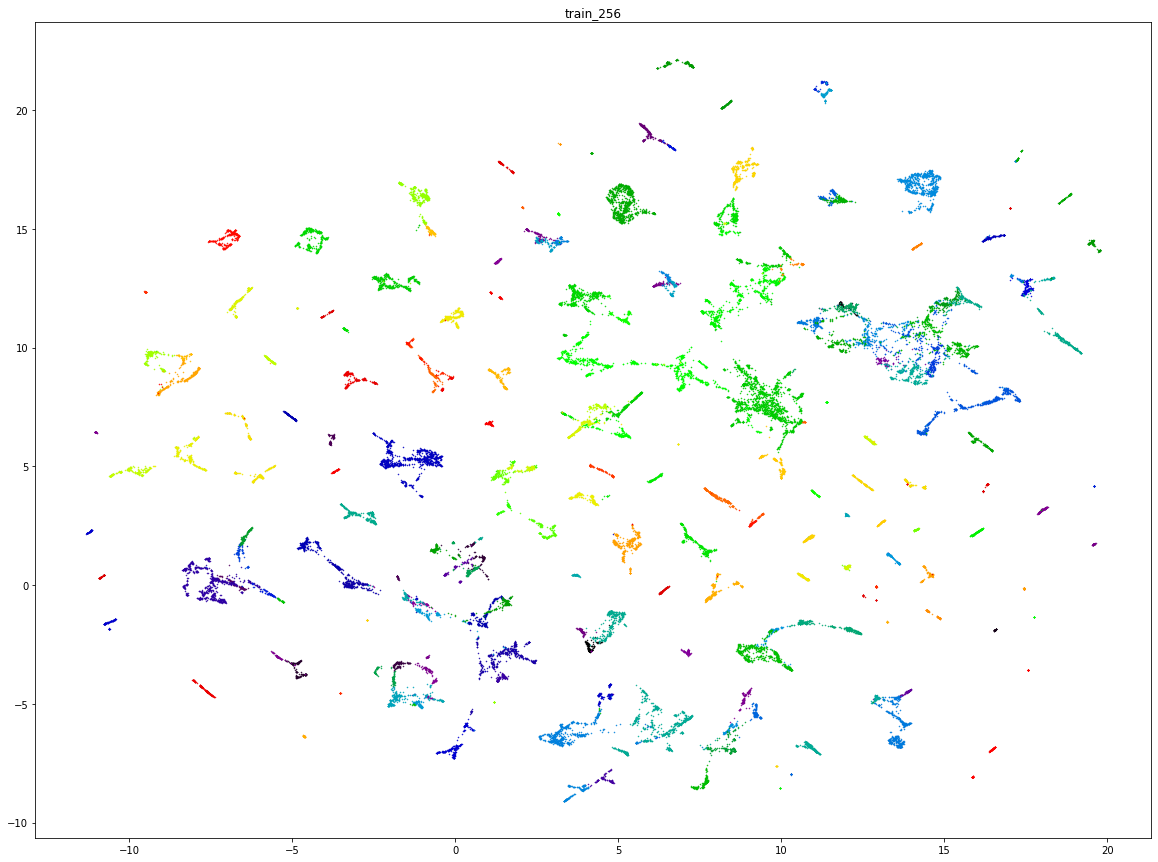

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


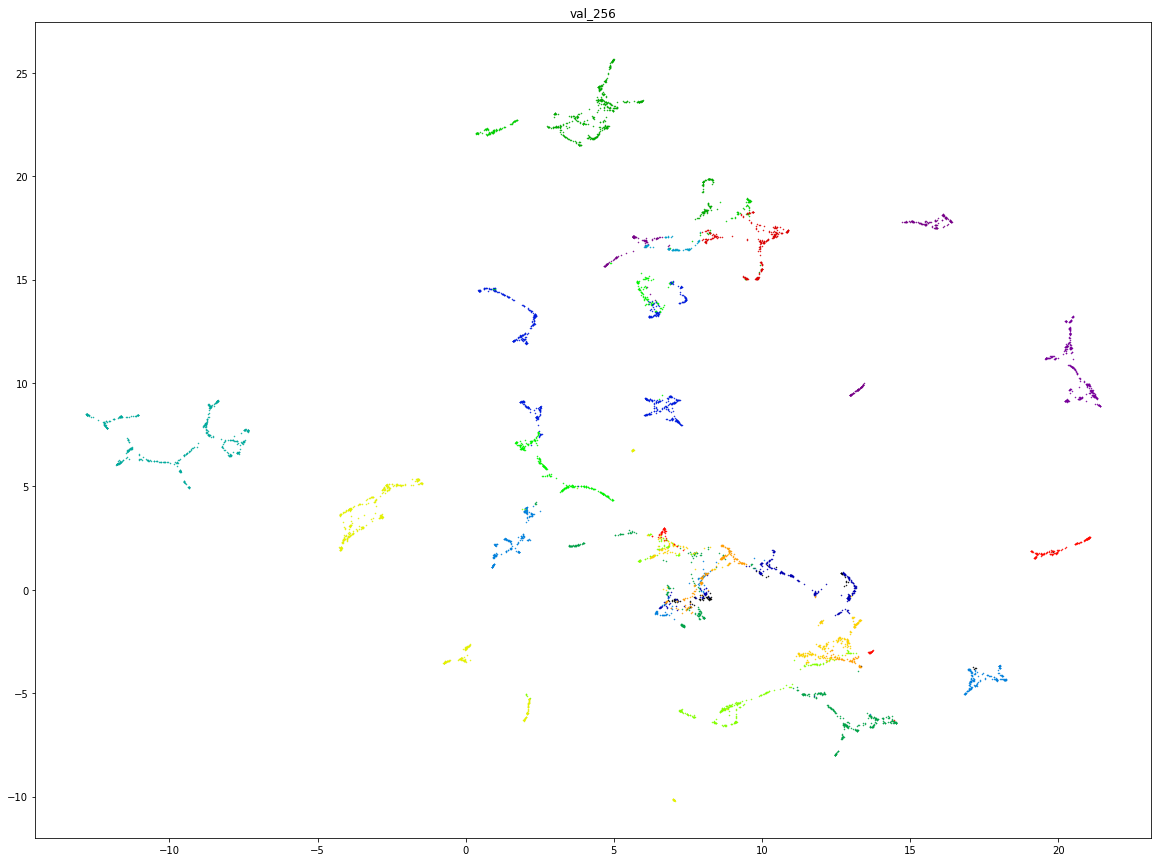

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.46024141139289954
INFO:PML:TRAINING EPOCH 4
total_loss=0.22702: 100%|██████████| 1182/1182 [02:05<00:00,  9.45it/s]
INFO:PML:Evaluating epoch 4
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:37<00:00, 12.15it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:17<00:00, 10.78it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


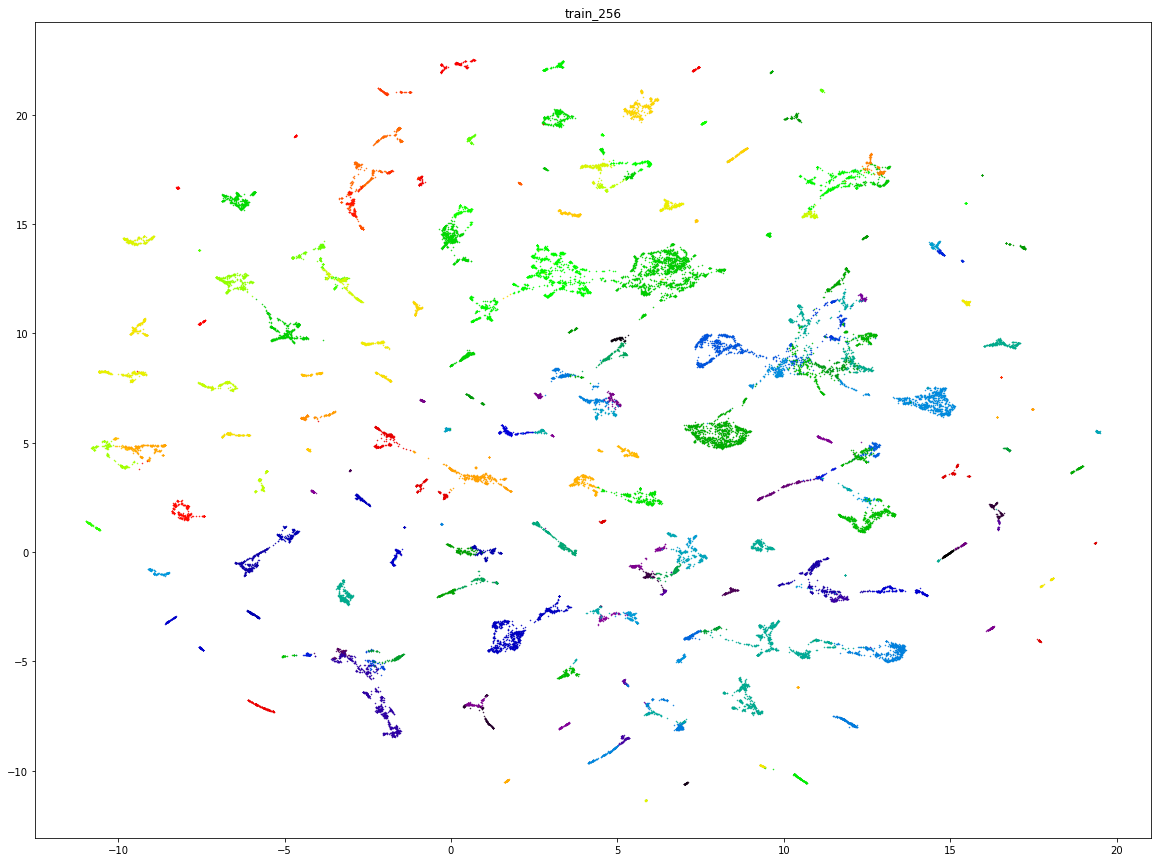

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


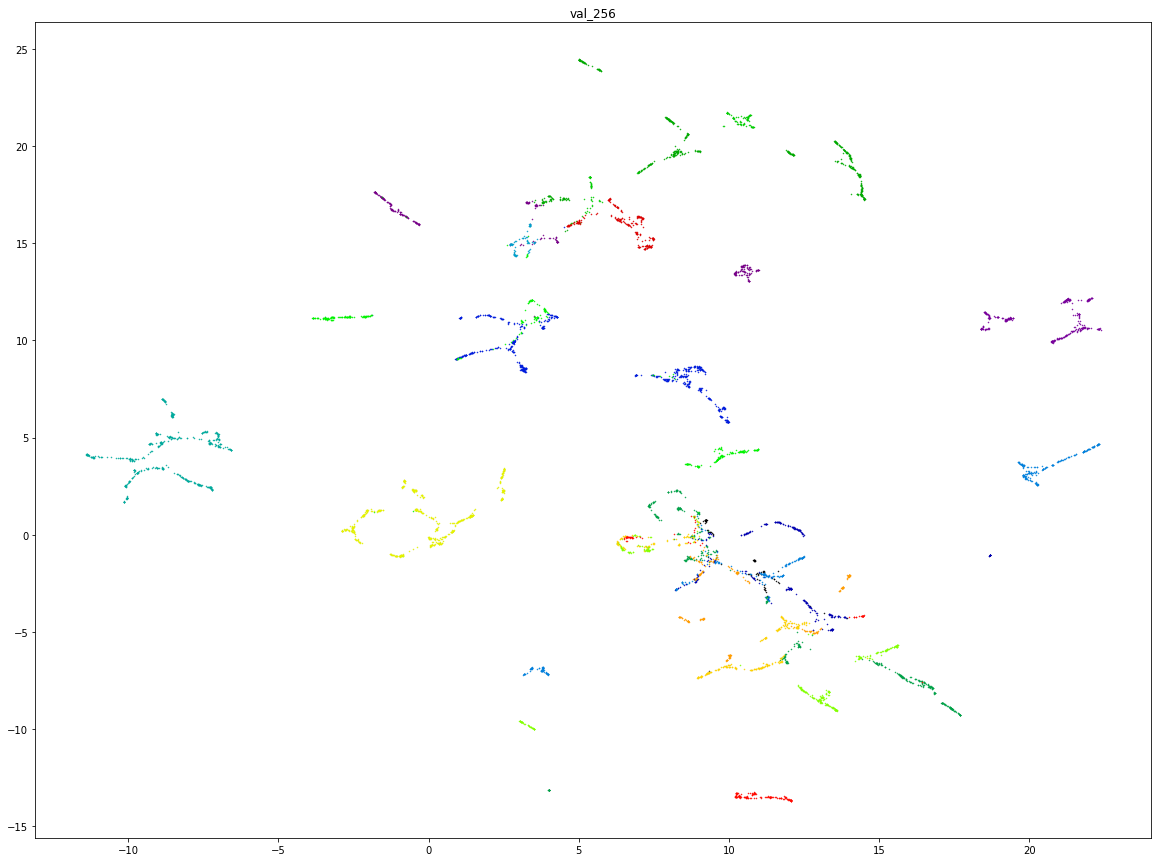

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:TRAINING EPOCH 5
total_loss=0.09338: 100%|██████████| 1182/1182 [02:08<00:00,  9.21it/s]
INFO:PML:Evaluating epoch 5
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:37<00:00, 12.23it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:17<00:00, 10.84it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


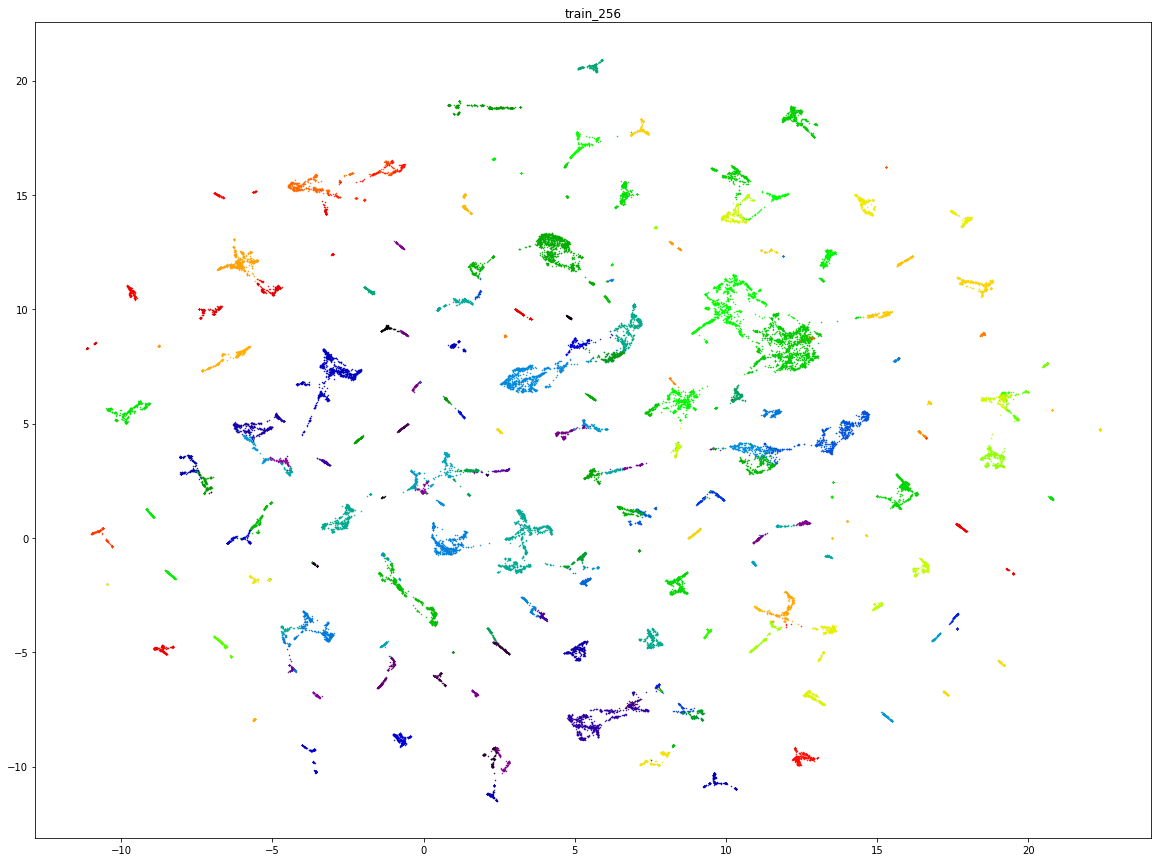

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


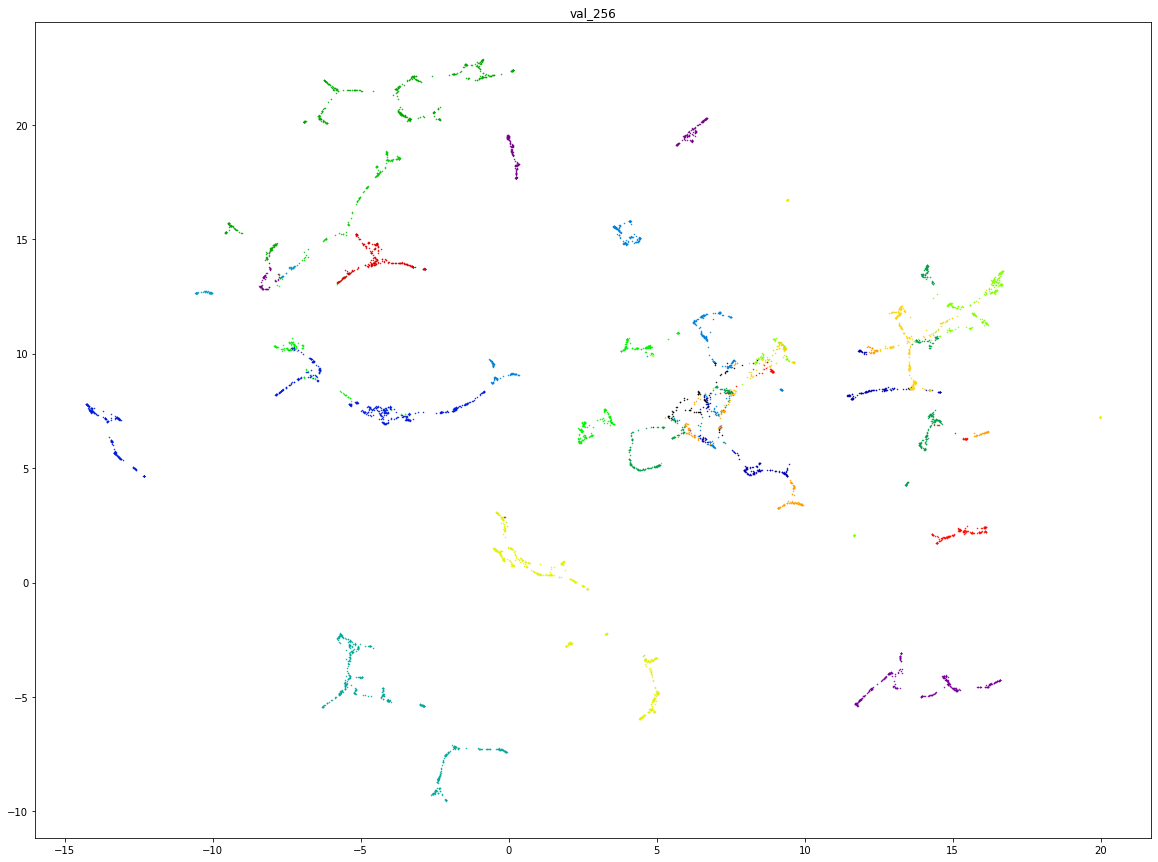

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.46833399146071863
INFO:PML:TRAINING EPOCH 6
total_loss=0.06672: 100%|██████████| 1182/1182 [02:09<00:00,  9.10it/s]
INFO:PML:Evaluating epoch 6
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:39<00:00, 12.00it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:17<00:00, 10.75it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


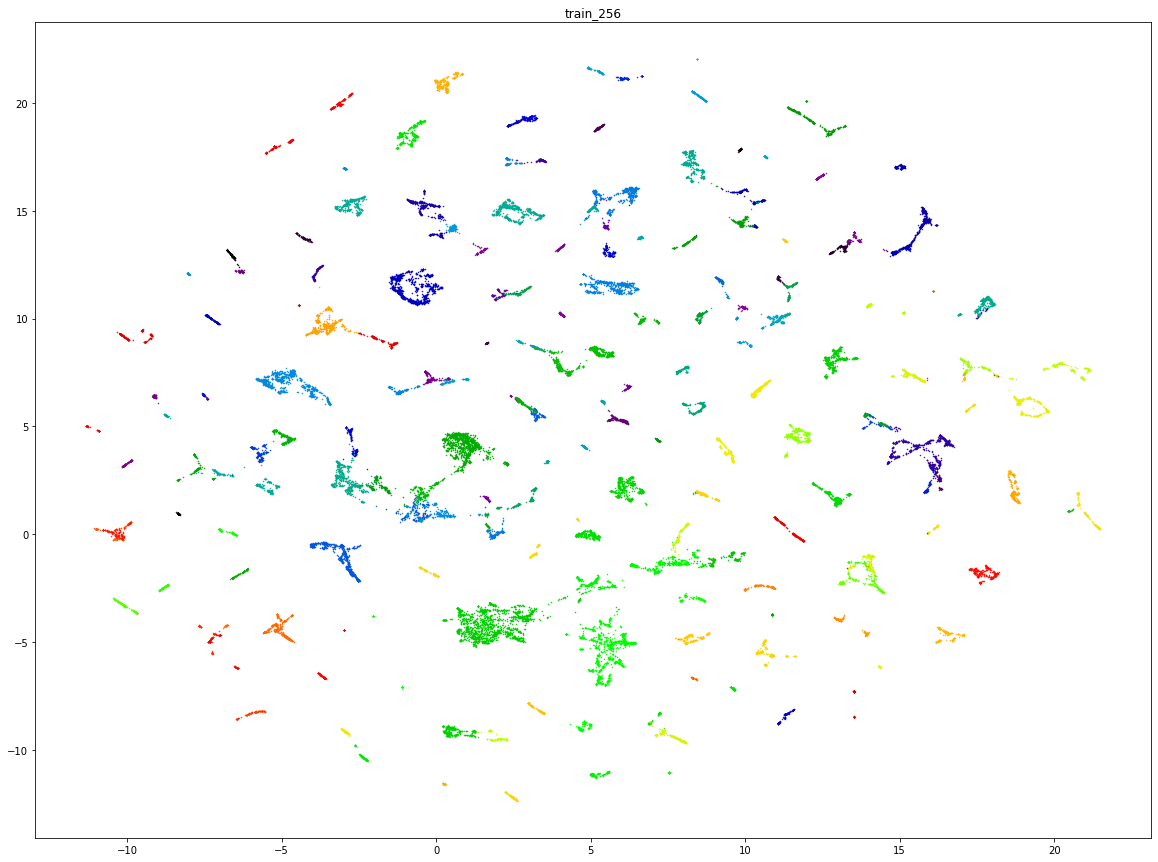

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


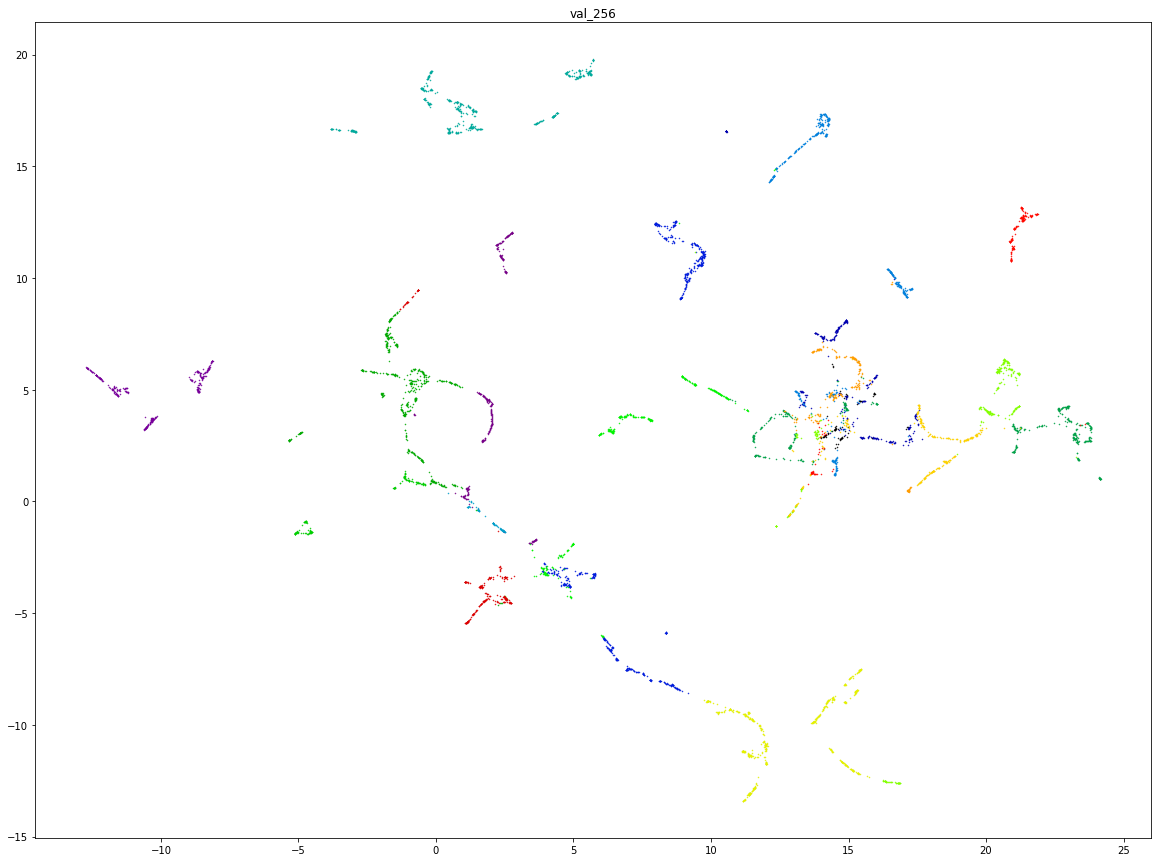

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:TRAINING EPOCH 7
total_loss=0.11145: 100%|██████████| 1182/1182 [02:13<00:00,  8.87it/s]
INFO:PML:Evaluating epoch 7
INFO:PML:Getting embeddings for the train split
100%|██████████| 1190/1190 [01:39<00:00, 11.98it/s]
INFO:PML:Getting embeddings for the val split
100%|██████████| 193/193 [00:18<00:00, 10.68it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


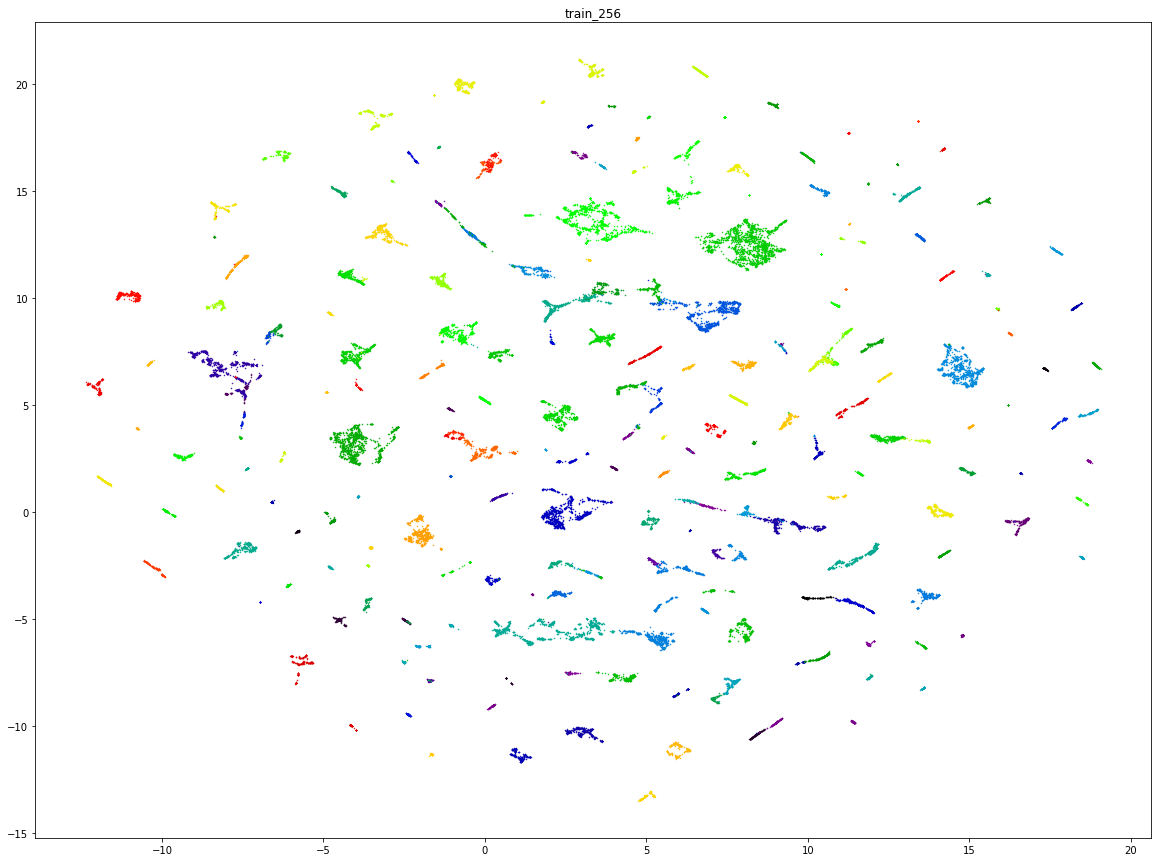

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


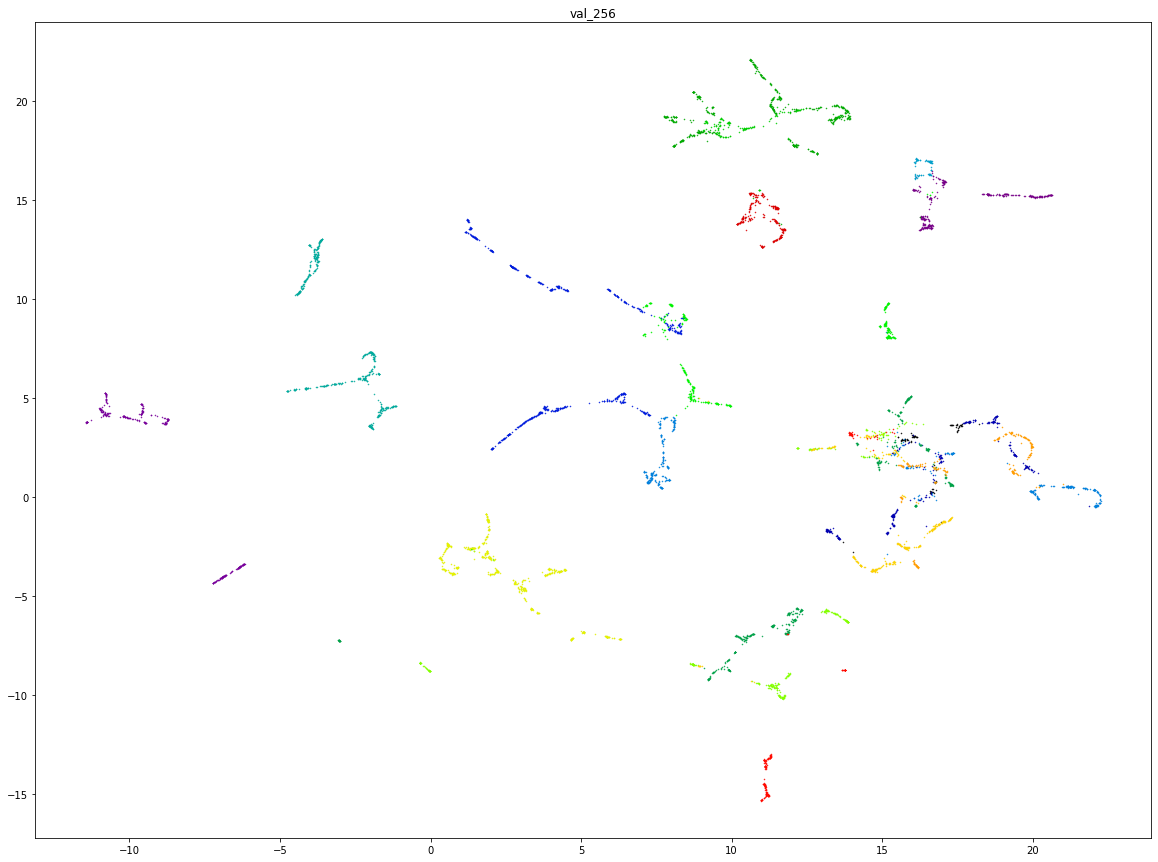

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=636
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=18
INFO:PML:embedding dimensionality is 256
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1668
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=166
INFO:PML:embedding dimensionality is 256
INFO:PML:Validation accuracy has plateaued. Exiting.


Model saved in  /content/drive/MyDrive/M6-T6-Project-master/Week5/model/0001_32_256


In [ ]:
train(train_data, test_data, save_model, epochs, lr, embeddings, batch_size)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir model/0001_32_256/example_tensorboard
#%reload_ext tensorboard